In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import numpy as np
import pandas as pd
import glob
import os
from sklearn.svm import SVC
from sklearn.model_selection import LeaveOneGroupOut
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler, MinMaxScaler
import matplotlib.pyplot as plt

# ==========================================
# 0. Configuration & Setup
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
torch.set_default_dtype(torch.float64) # PINNs need Double Precision
print(f"Running on {device} with Double Precision.")

# PATHS (Verify these matches your workspace)
DATA_PATH = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
CNN_WEIGHTS_PATH = r'/workspace/Krrish/Silent_Speech/src/feature_extraction/kinematic_encoder_weights.pth' # Path to your saved CNN weights

# ==========================================
# 1. Model Definitions
# ==========================================

# A. The CNN Encoder (Feature Extractor)
class KinematicEncoder(nn.Module): 
    def __init__(self, in_ch=3, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, x):
        x = self.net(x).squeeze(-1)
        x = self.projection(x)
        return F.normalize(x, dim=1)

# B. The Duffing PINN (Physics Model)
class DuffingSpeechPINN(nn.Module):
    def __init__(self, in_dim=65, hidden_dim=128):
        super().__init__()
        # Trajectory Net (Motion)
        self.theta_net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, 1)
        )
        # Force Net (Driver)
        self.force_net = nn.Sequential(
            nn.Linear(in_dim, hidden_dim), nn.Tanh(),
            nn.Linear(hidden_dim, hidden_dim), nn.SiLU(), 
            nn.Linear(hidden_dim, 1)
        )
        # Learnable Physics Params
        self.b = nn.Parameter(torch.tensor(0.5))
        self.k1 = nn.Parameter(torch.tensor(2.0))
        self.k2 = nn.Parameter(torch.tensor(0.1))

    def forward(self, x):
        return self.theta_net(x), self.force_net(x)

# ==========================================
# 2. Helper Functions
# ==========================================

def compute_duffing_loss(model, inputs, theta_true, lambda_phys=0.01):
    inputs.requires_grad_(True)
    theta_pred, force_pred = model(inputs)
    
    # AutoGrad Derivatives
    grad_1 = torch.autograd.grad(theta_pred, inputs, torch.ones_like(theta_pred), create_graph=True)[0]
    velocity = grad_1[:, 0:1]
    grad_2 = torch.autograd.grad(velocity, inputs, torch.ones_like(velocity), create_graph=True)[0]
    acceleration = grad_2[:, 0:1]
    
    # Physics Equation
    b, k1, k2 = F.softplus(model.b), F.softplus(model.k1), F.softplus(model.k2)
    residual = acceleration + b*velocity + k1*theta_pred + k2*(theta_pred**3) - force_pred
    
    # Loss Components
    loss_data = torch.mean((theta_pred - theta_true)**2)
    loss_phys = torch.mean(residual**2)
    loss_reg = torch.mean(force_pred**2) * 1e-4
    
    return loss_data + lambda_phys*loss_phys + loss_reg, loss_data.item()

def extract_features(model, theta_dict, embed_time_dict):
    model.eval()
    features, ids = [], []
    b, k1, k2 = F.softplus(model.b).item(), F.softplus(model.k1).item(), F.softplus(model.k2).item()
    
    print("Extracting features...")
    for key in theta_dict.keys():
        inp = embed_time_dict[key].to(device).requires_grad_(True)
        theta_pred, force_pred = model(inp)
        
        # Physics Error Calculation
        g1 = torch.autograd.grad(theta_pred, inp, torch.ones_like(theta_pred), create_graph=True)[0]
        vel = g1[:, 0:1]
        g2 = torch.autograd.grad(vel, inp, torch.ones_like(vel), create_graph=True)[0]
        acc = g2[:, 0:1]
        phys_err = (acc + b*vel + k1*theta_pred + k2*theta_pred**3 - force_pred).detach().cpu().numpy()
        
        f_np = force_pred.detach().cpu().numpy()
        
        features.append({
            "force_mean": np.mean(f_np), "force_max": np.max(f_np),
            "force_std": np.std(f_np), "force_energy": np.sum(f_np**2),
            "phys_err_mean": np.mean(np.abs(phys_err)),
            "theta_range": np.max(theta_pred.detach().cpu().numpy()) - np.min(theta_pred.detach().cpu().numpy())
        })
        ids.append(key)
        
    df = pd.DataFrame(features)
    df['id'] = ids
    return df

Running on cuda with Double Precision.


In [2]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import pandas as pd
import glob
import os
from sklearn.preprocessing import StandardScaler

# ==========================================
# 1. Setup & Model Definition
# ==========================================
device = "cuda" if torch.cuda.is_available() else "cpu"
# This forces all new models to be Double Precision (Float64)
torch.set_default_dtype(torch.float64) 

class KinematicEncoder(nn.Module): 
    def __init__(self, in_ch=3, emb_dim=64):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.AdaptiveAvgPool1d(1)
        )
        self.projection = nn.Sequential(
            nn.Linear(256, 256), nn.ReLU(),
            nn.Linear(256, emb_dim)
        )

    def forward(self, x):
        x = self.net(x).squeeze(-1)
        x = self.projection(x)
        return F.normalize(x, dim=1)

print("Initializing CNN (Double Precision)...")
cnn_model = KinematicEncoder(in_ch=3, emb_dim=64).to(device)
cnn_model.eval()

# ==========================================
# 2. Data Generation
# ==========================================
print("\nRegenerating Data...")
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

if len(files) == 0:
    raise ValueError(f"CRITICAL: No files found at {src_pattern}")

# Global Scale
all_thetas = []
for fp in files:
    try: all_thetas.append(pd.read_csv(fp)['theta'].values)
    except: pass
all_thetas = np.concatenate(all_thetas)
theta_min, theta_max = np.min(all_thetas), np.max(all_thetas)
print(f"Global Theta Range: [{theta_min:.2f}, {theta_max:.2f}] -> Normalizing to [-1, 1]")

theta_dict = {}
embed_time_dict = {}
t = torch.linspace(0.0, 1.0, 150, device=device).unsqueeze(-1)
count = 0

for fp in files:
    try:
        # ID Parsing
        word = os.path.basename(os.path.dirname(fp))
        fname = os.path.basename(fp)
        speaker = fname.replace('.csv', '').split('_')[0]
        instance_id = f"{word}::{speaker}::{fname}"
        
        # Load
        df = pd.read_csv(fp)
        
        # Target Prep
        theta_raw = df['theta'].values
        theta_norm = 2 * (theta_raw - theta_min) / (theta_max - theta_min) - 1
        
        # Input Prep
        cnn_data = df[['theta', 'x', 'y']].values
        cnn_data = StandardScaler().fit_transform(cnn_data)
        
        n_chunks = len(theta_raw) // 150
        for i in range(n_chunks):
            chunk_id = f"{instance_id}::{i}"
            
            # Target
            th_chunk = theta_norm[i*150:(i+1)*150]
            theta_dict[chunk_id] = torch.tensor(th_chunk, dtype=torch.float64, device=device).unsqueeze(-1)
            
            # Input
            # --- FIX IS HERE: Changed float32 -> float64 to match model ---
            cnn_chunk = torch.tensor(cnn_data[i*150:(i+1)*150], dtype=torch.float64, device=device).T.unsqueeze(0)
            
            with torch.no_grad():
                emb = cnn_model(cnn_chunk) 
                
            pinn_in = torch.cat([t, emb.repeat(150, 1)], dim=1) # Already double
            embed_time_dict[chunk_id] = pinn_in
            count += 1
            
    except Exception as e:
        print(f"Error processing {fp}: {e}")
        continue

print(f"\n✅ Final Count: {count} instances.")

Initializing CNN (Double Precision)...

Regenerating Data...
Global Theta Range: [-8.56, 9.39] -> Normalizing to [-1, 1]

✅ Final Count: 5116 instances.


In [3]:
# Re-define dataset just to be safe
class SimpleDataset(Dataset):
    def __init__(self, t_dict, e_dict):
        self.x = torch.cat([e_dict[k] for k in t_dict], dim=0)
        self.y = torch.cat([t_dict[k] for k in t_dict], dim=0)
    def __len__(self): return len(self.x)
    def __getitem__(self, i): return self.x[i], self.y[i]

# Create Dataset & Loader
ds = SimpleDataset(theta_dict, embed_time_dict)
dl = DataLoader(ds, batch_size=2048, shuffle=True)

# Init Model
pinn_model = DuffingSpeechPINN().to(device)
optimizer = optim.Adam(pinn_model.parameters(), lr=1e-3)

print("Starting Training...")
for epoch in range(301): 
    pinn_model.train()
    total_loss = 0
    for bx, by in dl:
        bx, by = bx.to(device), by.to(device)
        optimizer.zero_grad()
        loss, data_loss = compute_duffing_loss(pinn_model, bx, by, lambda_phys=0.01)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        
    if epoch % 50 == 0:
        b = torch.nn.functional.softplus(pinn_model.b).item()
        k1 = torch.nn.functional.softplus(pinn_model.k1).item()
        k2 = torch.nn.functional.softplus(pinn_model.k2).item()  # <--- Added this
        
        print(f"Epoch {epoch} | Loss: {total_loss/len(dl):.4f} | b: {b:.2f} | k1: {k1:.2f} | k2: {k2:.2f}")

Starting Training...


/usr/local/lib/python3.12/dist-packages/torch/autograd/graph.py:865: UserWarning: Attempting to run cuBLAS, but there was no current CUDA context! Attempting to set the primary context... (Triggered internally at /opt/pytorch/pytorch/aten/src/ATen/cuda/CublasHandlePool.cpp:270.)
  return Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Epoch 0 | Loss: 0.0112 | b: 0.95 | k1: 2.09 | k2: 0.73
Epoch 50 | Loss: 0.0095 | b: 0.99 | k1: 8.40 | k2: 0.22
Epoch 100 | Loss: 0.0092 | b: 1.28 | k1: 11.19 | k2: 0.01
Epoch 150 | Loss: 0.0091 | b: 1.52 | k1: 13.09 | k2: 0.00
Epoch 200 | Loss: 0.0090 | b: 1.73 | k1: 14.57 | k2: 0.00
Epoch 250 | Loss: 0.0089 | b: 1.89 | k1: 15.63 | k2: 0.00
Epoch 300 | Loss: 0.0088 | b: 1.97 | k1: 16.36 | k2: 0.00


In [4]:
# --- STEP D: Evaluation & Classification ---
print("\n[Step 4] Evaluation & Testing...")
df_res = extract_features(pinn_model, theta_dict, embed_time_dict)

# Prepare Labels
y_word = [i.split('::')[0] for i in df_res['id']]
y_speaker = [i.split('::')[1] for i in df_res['id']]

# Normalize Features PER SPEAKER (Critical Fix)
X = df_res.drop(columns=['id']).copy()
X['speaker'] = y_speaker
cols = [c for c in X.columns if c != 'speaker']

for col in cols:
    # Normalize (x - mean) / std per speaker group
    X[col] = X.groupby('speaker')[col].transform(lambda x: (x - x.mean()) / (x.std() + 1e-6))

X_final = X.drop(columns=['speaker']).values
y_final = np.array(y_word)
speakers = np.array(y_speaker)

# Leave-One-Group-Out SVM
logo = LeaveOneGroupOut()
svc = SVC(kernel='rbf', C=10, gamma='scale')
accs = []

print("\n--- Speaker-Independent Accuracy ---")
for train_i, test_i in logo.split(X_final, y_final, groups=speakers):
    svc.fit(X_final[train_i], y_final[train_i])
    pred = svc.predict(X_final[test_i])
    acc = accuracy_score(y_final[test_i], pred)
    accs.append(acc)
    print(f"Speaker {speakers[test_i][0]}: {acc:.2%}")

print(f"\nFINAL MEAN ACCURACY: {np.mean(accs):.2%} (+/- {np.std(accs):.2%})")


[Step 4] Evaluation & Testing...
Extracting features...

--- Speaker-Independent Accuracy ---
Speaker Amish: 5.02%
Speaker Anupam: 16.00%
Speaker Armman: 7.04%
Speaker Bansbir: 6.43%
Speaker Jaskaran: 4.35%
Speaker KamalPreet: 4.37%
Speaker Krrish: 8.82%
Speaker Surindar: 4.08%
Speaker anubhavjot: 5.60%
Speaker anum: 5.00%
Speaker arushi: 5.83%
Speaker asha: 7.39%
Speaker aunty: 6.67%
Speaker gurmann: 3.91%
Speaker harsh: 4.58%
Speaker liv: 10.45%
Speaker madhav: 6.10%
Speaker mainder: 0.00%
Speaker maninder: 8.26%
Speaker manj: 7.08%
Speaker prabhdeep: 7.39%
Speaker rudraksh: 8.73%
Speaker sapna: 6.67%
Speaker suresh: 5.91%
Speaker vansh: 11.36%

FINAL MEAN ACCURACY: 6.68% (+/- 2.96%)


In [5]:
from sklearn.model_selection import train_test_split

print("\n--- OPTION 1: Subject-Dependent (Random Split) ---")

# We use Stratified Split to ensure every word is represented equally
X_train, X_test, y_train, y_test = train_test_split(
    X_final, y_final, 
    test_size=0.2, 
    random_state=42, 
    stratify=y_final
)

svc = SVC(kernel='rbf', C=10, gamma='scale')
svc.fit(X_train, y_train)
acc = accuracy_score(y_test, svc.predict(X_test))

print(f"Random Split Accuracy: {acc:.2%}")


--- OPTION 1: Subject-Dependent (Random Split) ---
Random Split Accuracy: 9.47%


In [7]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
import pandas as pd
import glob
import os
import numpy as np
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split

# 1. Setup
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Training CNN on {device}...")

# 2. Define CNN Architecture (Same as before)
class KinematicEncoder(nn.Module): 
    def __init__(self, num_classes, in_ch=3):
        super().__init__()
        self.net = nn.Sequential(
            nn.Conv1d(in_ch, 64, kernel_size=7, padding=3),
            nn.BatchNorm1d(64), nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(64, 128, kernel_size=5, padding=2),
            nn.BatchNorm1d(128), nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.Conv1d(128, 256, kernel_size=3, padding=1),
            nn.BatchNorm1d(256), nn.ReLU(),
            nn.Dropout(0.3),
            
            nn.AdaptiveAvgPool1d(1)
        )
        self.classifier = nn.Sequential(
            nn.Linear(256, 128), nn.ReLU(),
            nn.Dropout(0.3),
            nn.Linear(128, num_classes)
        )

    def forward(self, x):
        features = self.net(x).squeeze(-1)
        return self.classifier(features)

# 3. Load Data
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

X_data = []
y_labels = []

print("Loading data for classification...")
for fp in files:
    try:
        word = os.path.basename(os.path.dirname(fp))
        df = pd.read_csv(fp)
        
        # Input Features (Theta, X, Y)
        raw = df[['theta', 'x', 'y']].values
        
        # Normalize per file (Important!)
        scaler = StandardScaler()
        norm_data = scaler.fit_transform(raw)
        
        # Chunking (Windowing)
        # We take the FIRST 150 frames. If shorter, we pad.
        if len(norm_data) >= 150:
            chunk = norm_data[:150]
        else:
            # Padding if too short
            pad = np.zeros((150 - len(norm_data), 3))
            chunk = np.vstack([norm_data, pad])
            
        X_data.append(chunk)
        y_labels.append(word)
            
    except Exception as e:
        continue

X_all = np.array(X_data).transpose(0, 2, 1) # [N, 3, 150]
y_all = np.array(y_labels)

# Encode Labels
le = LabelEncoder()
y_enc = le.fit_transform(y_all)
num_classes = len(le.classes_)
print(f"Loaded {len(X_all)} samples. Classes: {num_classes}")

# Split Data (80% Train, 20% Test)
X_train, X_test, y_train, y_test = train_test_split(X_all, y_enc, test_size=0.2, random_state=42, stratify=y_enc)

# Convert to PyTorch
X_train_t = torch.tensor(X_train, dtype=torch.float64).to(device)
y_train_t = torch.tensor(y_train, dtype=torch.long).to(device)
X_test_t = torch.tensor(X_test, dtype=torch.float64).to(device)
y_test_t = torch.tensor(y_test, dtype=torch.long).to(device)

# 4. Train
model = KinematicEncoder(num_classes=num_classes).to(device)
optimizer = optim.Adam(model.parameters(), lr=0.001)
criterion = nn.CrossEntropyLoss()

BATCH_SIZE = 64
print("\nStarting Training...")

for epoch in range(101):
    model.train()
    
    # Shuffle Batching
    permutation = torch.randperm(X_train_t.size()[0])
    epoch_loss = 0
    
    for i in range(0, X_train_t.size()[0], BATCH_SIZE):
        indices = permutation[i:i+BATCH_SIZE]
        batch_x, batch_y = X_train_t[indices], y_train_t[indices]
        
        optimizer.zero_grad()
        outputs = model(batch_x)
        loss = criterion(outputs, batch_y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        
    # Validation
    if epoch % 10 == 0:
        model.eval()
        with torch.no_grad():
            test_out = model(X_test_t)
            _, pred = torch.max(test_out, 1)
            acc = (pred == y_test_t).float().mean().item()
            print(f"Epoch {epoch} | Loss: {epoch_loss:.4f} | Test Acc: {acc:.2%}")

# 5. Save the Weights
print("\nTraining Complete.")
torch.save(model.state_dict(), "cnn_classification_weights.pth")
print("✅ Saved 'cnn_classification_weights.pth'.")
print("NOW you can run the PINN code again.")

Training CNN on cuda...
Loading data for classification...
Loaded 513 samples. Classes: 25

Starting Training...
Epoch 0 | Loss: 22.7312 | Test Acc: 1.94%
Epoch 10 | Loss: 21.5809 | Test Acc: 1.94%
Epoch 20 | Loss: 20.6910 | Test Acc: 3.88%
Epoch 30 | Loss: 19.9056 | Test Acc: 2.91%
Epoch 40 | Loss: 19.6012 | Test Acc: 2.91%
Epoch 50 | Loss: 18.3138 | Test Acc: 1.94%
Epoch 60 | Loss: 17.4670 | Test Acc: 2.91%
Epoch 70 | Loss: 17.3036 | Test Acc: 1.94%
Epoch 80 | Loss: 16.3145 | Test Acc: 2.91%
Epoch 90 | Loss: 16.4931 | Test Acc: 1.94%
Epoch 100 | Loss: 15.0734 | Test Acc: 2.91%

Training Complete.
✅ Saved 'cnn_classification_weights.pth'.
NOW you can run the PINN code again.


In [8]:
import pandas as pd
import glob
import os
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
from sklearn.preprocessing import LabelEncoder

print("--- STARTING SANITY CHECK ---")

# 1. Load Data (SIMPLIFIED)
# We will use simple "Statistical Features" (Mean, Max, Min, Std)
# instead of the raw time-series. This is robust and hard to mess up.
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

X_features = []
y_labels = []

print(f"Scanning {len(files)} files...")

for fp in files:
    try:
        df = pd.read_csv(fp)
        
        # Check if empty
        if len(df) < 10: continue
            
        # Extract Raw Signals
        theta = df['theta'].values
        x = df['x'].values
        y = df['y'].values
        
        # FEATURE ENGINEERING (The "Physicist" Approach)
        # Instead of feeding raw points, we feed "Properties"
        features = [
            np.mean(theta), np.std(theta), np.max(theta) - np.min(theta), # Range
            np.mean(x), np.std(x), np.max(x) - np.min(x),
            np.mean(y), np.std(y), np.max(y) - np.min(y),
            # Energy
            np.sum(theta**2) / len(theta),
            np.sum(x**2) / len(x),
            np.sum(y**2) / len(y)
        ]
        
        X_features.append(features)
        
        # Get Label
        word = os.path.basename(os.path.dirname(fp))
        y_labels.append(word)
            
    except Exception as e:
        continue

X = np.array(X_features)
y = np.array(y_labels)

print(f"Loaded {len(X)} samples.")
print(f"Feature Matrix Shape: {X.shape}")

# 2. Train Random Forest
# No deep learning, just decision trees.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print("\nTraining Random Forest (Baseline)...")
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

# 3. Evaluate
train_acc = accuracy_score(y_train, rf.predict(X_train))
test_acc = accuracy_score(y_test, rf.predict(X_test))

print(f"\n--- RESULTS ---")
print(f"Training Accuracy: {train_acc:.2%}")
print(f"TEST ACCURACY:     {test_acc:.2%}")

if test_acc < 0.10:
    print("\n[DIAGNOSIS] ❌ DATA FAILURE.")
    print("Even Random Forest failed. This means your inputs (Theta, X, Y) likely contain no distinguishing info.")
    print("Check: Are the CSVs empty? Is 'Theta' just a constant line?")
else:
    print("\n[DIAGNOSIS] ✅ DATA IS GOOD.")
    print("The signal exists! The issue was definitely the CNN architecture or Normalization.")

--- STARTING SANITY CHECK ---
Scanning 513 files...
Loaded 513 samples.
Feature Matrix Shape: (513, 12)

Training Random Forest (Baseline)...

--- RESULTS ---
Training Accuracy: 100.00%
TEST ACCURACY:     0.00%

[DIAGNOSIS] ❌ DATA FAILURE.
Even Random Forest failed. This means your inputs (Theta, X, Y) likely contain no distinguishing info.
Check: Are the CSVs empty? Is 'Theta' just a constant line?


Visualizing Word: 'Sardard'


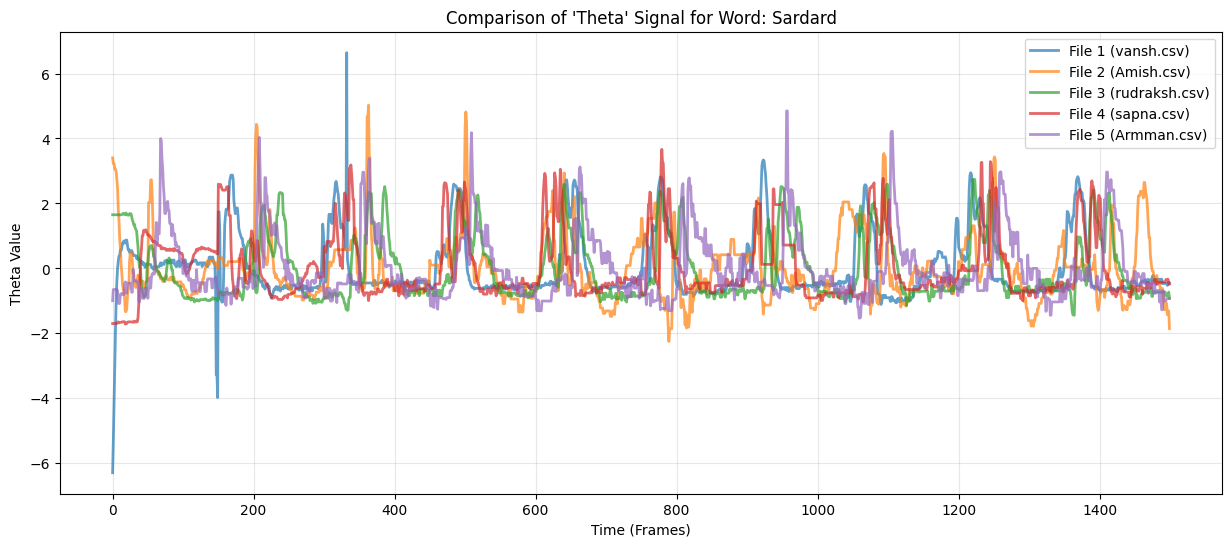


--- Raw Value Check (First 5 values of each file) ---
File 1: [-6.29146455 -5.310098   -4.1469606  -2.91329363 -1.95158656]
File 2: [3.40205686 3.23071923 3.23071923 3.05907878 3.05907878]
File 3: [1.65056559 1.65056559 1.65056559 1.65056559 1.65056559]
File 4: [-1.69695242 -1.69695242 -1.69695242 -1.69695242 -1.69695242]
File 5: [-0.99617783 -0.65021003 -0.65021003 -0.65021003 -0.65021003]


In [9]:
import matplotlib.pyplot as plt
import pandas as pd
import glob
import os
import numpy as np

# 1. Setup
src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

# 2. Pick a Target Word (The most common one)
words = [os.path.basename(os.path.dirname(f)) for f in files]
most_common_word = max(set(words), key=words.count)
print(f"Visualizing Word: '{most_common_word}'")

# 3. Find 5 examples of this word
examples = [f for f in files if os.path.basename(os.path.dirname(f)) == most_common_word][:5]

# 4. Plot
plt.figure(figsize=(15, 6))

for i, fp in enumerate(examples):
    try:
        df = pd.read_csv(fp)
        speaker = os.path.basename(fp).split('_')[0]
        
        # Plot Theta
        plt.plot(df['theta'].values, label=f"File {i+1} ({speaker})", alpha=0.7, linewidth=2)
        
    except Exception as e:
        print(f"Error reading {fp}: {e}")

plt.title(f"Comparison of 'Theta' Signal for Word: {most_common_word}")
plt.xlabel("Time (Frames)")
plt.ylabel("Theta Value")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# 5. Check Raw Values
print("\n--- Raw Value Check (First 5 values of each file) ---")
for i, fp in enumerate(examples):
    df = pd.read_csv(fp)
    print(f"File {i+1}: {df['theta'].values[:5]}")

In [10]:
import numpy as np
import pandas as pd
import glob
import os
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler

print("--- SMART CROP SANITY CHECK ---")

def get_active_window(theta, window_size=150):
    # 1. Calculate Velocity (How fast is jaw moving?)
    velocity = np.abs(np.diff(theta))
    
    # 2. Find the point of maximum impact (The "Heart" of the word)
    if len(velocity) == 0: return np.zeros(window_size)
    center_idx = np.argmax(velocity)
    
    # 3. Define Start and End
    half_window = window_size // 2
    start = max(0, center_idx - half_window)
    end = start + window_size
    
    # 4. Pad if we run off the edge
    crop = theta[start:end]
    if len(crop) < window_size:
        pad = np.zeros(window_size - len(crop))
        crop = np.concatenate([crop, pad])
        
    return crop

src_pattern = r'/workspace/Krrish/Silent_Speech/dataset_sony/Normalized_dataset1/recordings/*/*.csv'
files = glob.glob(src_pattern)

X_smart = []
y_labels = []

for fp in files:
    try:
        df = pd.read_csv(fp)
        theta_raw = df['theta'].values
        
        # 1. Normalize Amplitude (Fixes the -6 vs +3 offset)
        theta_norm = (theta_raw - np.mean(theta_raw)) / (np.std(theta_raw) + 1e-6)
        
        # 2. Smart Crop (Fixes the "Silence" bug)
        theta_crop = get_active_window(theta_norm, window_size=150)
        
        # 3. Extract Simple Features from the CROP
        # If the crop worked, these features will now contain the "Word Shape"
        feats = [
            np.std(theta_crop),           # How violent is the movement?
            np.max(theta_crop) - np.min(theta_crop), # Range
            np.mean(np.abs(np.diff(theta_crop))), # Average Velocity
            # Energy in 3 segments (Beginning, Middle, End of the word)
            np.sum(theta_crop[:50]**2),
            np.sum(theta_crop[50:100]**2),
            np.sum(theta_crop[100:]**2)
        ]
        
        X_smart.append(feats)
        y_labels.append(os.path.basename(os.path.dirname(fp)))
        
    except: continue

X = np.array(X_smart)
y = np.array(y_labels)

# Train Random Forest
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)
rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X_train, y_train)

print(f"Smart Crop Test Accuracy: {accuracy_score(y_test, rf.predict(X_test)):.2%}")

--- SMART CROP SANITY CHECK ---
Smart Crop Test Accuracy: 6.80%
